#Car Dataset Project Analysis
### 1. Objectives of the Project

# Upload Dataset

In [22]:
# Raw Car Dataset
from google.colab import files
up = files.upload()  # choose file car_dataset.csv

import os, shutil
csv_name = next(iter(up))  # uploaded file name
target_path = "/content/cars.csv"  # standard name for the project
shutil.move(csv_name, target_path)
print("Saved as:", target_path)



Saving car_dataset.csv to car_dataset (3).csv
Saved as: /content/cars.csv


#1. Imports Libraries for data analysis and manipulation.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# the dataset saved as cars.csv
file_path = "/content/cars.csv"
df = pd.read_csv(file_path)

# Dataset shape
print("Dataset shape")
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

# Quick preview
df.head()


Dataset shape
Rows: 11914
Columns: 16


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


#2 Data Cleaning
###2.1 Missing values overview

In [25]:
missing = (df.isna().sum()
           .reset_index()
           .rename(columns={"index": "Column", 0: "Missing_Count"}))
missing

,Column,Missing_Count
0,Make,0
1,Model,0
2,Year,0
3,Engine Fuel Type,3
4,Engine HP,69
5,Engine Cylinders,30
6,Transmission Type,0
7,Driven_Wheels,0
8,Number of Doors,6
9,Market Category,3742


###2.2 Fix data types (numeric coercion where expected)

In [26]:
numeric_cols = [
    "Year","Engine HP","Engine Cylinders","Number of Doors",
    "highway MPG","city mpg","Popularity","MSRP"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.dtypes


,0
Make,object
Model,object
Year,int64
Engine Fuel Type,object
Engine HP,float64
Engine Cylinders,float64
Transmission Type,object
Driven_Wheels,object
Number of Doors,float64
Market Category,object


###2.3 Filter to cars from 1995 and later

In [27]:
if "Year" in df.columns:
    df = df[df["Year"] >= 1995].copy()
df.shape

(11090, 16)

###2.4 Impute/handle missing values

####Rule of thumb (simple & explainable):
*  Numeric:  median of that column
*  Categorical: fill with "unknown"






In [29]:
# Numeric: median fill
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Categorical: 'unknown'
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("unknown")


###2.5 Remove Duplicate Rows

In [34]:
# Count exact duplicate rows (across all columns)
dup_count = df.duplicated(keep="first").sum()
print(f"Exact duplicate rows found: {dup_count}")

# Drop them, keep the first occurrence
df = df.drop_duplicates(keep="first").reset_index(drop=True)

print("Shape after dedup:", df.shape)


Exact duplicate rows found: 487
Shape after dedup: (10603, 16)


###2.6 String standardization (lowercase)

In [30]:
for col in ["Vehicle Style", "Market Category"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower()

###2.7 Snapshot after cleaning and save cleaned CSV

In [31]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"factory tuner,luxury,high-performance",Compact,coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"luxury,performance",Compact,convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"luxury,high-performance",Compact,coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"luxury,performance",Compact,coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,luxury,Compact,convertible,28,18,3916,34500


In [32]:
clean_path = "/content/cars_cleaned.csv"
df.to_csv(clean_path, index=False)
print("Cleaned dataset saved to:", clean_path)


Cleaned dataset saved to: /content/cars_cleaned.csv


#3. Feature Engineering
New Column Added
*   Total MPG = average of city mpg and highway
*   MPG Price per HP = MSRP / Engine HP (safe against zero)

In [35]:
if ("city mpg" in df.columns) and ("highway MPG" in df.columns):
    df["Total MPG"] = (df["city mpg"] + df["highway MPG"]) / 2.0

if ("MSRP" in df.columns) and ("Engine HP" in df.columns):
    df["Price per HP"] = np.where(df["Engine HP"] > 0,
                                  df["MSRP"] / df["Engine HP"],
                                  np.nan)

df[["city mpg","highway MPG","Total MPG","Engine HP","MSRP","Price per HP"]].head()


,city mpg,highway MPG,Total MPG,Engine HP,MSRP,Price per HP
0,19,26,22.5,335.0,46135,137.716418
1,19,28,23.5,300.0,40650,135.500000
2,20,28,24.0,300.0,36350,121.166667
3,18,28,23.0,230.0,29450,128.043478
4,18,28,23.0,230.0,34500,150.000000


### 3.1 Verfy new column data types

In [37]:
# DataFrame is df and column is MSRP
df[['Total MPG','Price per HP','MSRP']].dtypes


,0
Total MPG,float64
Price per HP,float64
MSRP,int64


### 3.2 Verify for unexpected NaN values

In [38]:
# Counts of NaNs (0 means clean)
df[['Total MPG','Price per HP','MSRP']].isna().sum()

,0
Total MPG,0
Price per HP,0
MSRP,0


#4 Exploratory Data Analysis (EDA)
###4.1 Descriptive statistics (mean, median, std)

In [42]:
stats_cols = ["Engine HP", "MSRP", "Popularity", "highway MPG", "city mpg"]
present = [c for c in stats_cols if c in df.columns]

desc = df[present].agg(["mean","median","std"]).T.reset_index()
desc.columns = ["Column","Mean","Median","Std"]
desc

,Column,Mean,Median,Std
0,Engine HP,259.005564,240.0,109.275400
1,MSRP,44159.006036,31630.0,62495.066118
2,Popularity,1575.327360,1385.0,1459.065850
3,highway MPG,26.746298,26.0,9.120727
4,city mpg,19.831840,18.0,9.371049


###4.2 Group analysis (avg MSRP & Popularity)
* Driven_Wheels
* Vehicle Size
* Engine Cylinders

In [43]:
def group_means(group_col):
    cols = [c for c in ["MSRP","Popularity"] if c in df.columns]
    if group_col in df.columns and cols:
        g = df.groupby(group_col, dropna=False)[cols].mean().reset_index()
        # Sort by MSRP if present, otherwise by first metric
        sort_col = "MSRP" if "MSRP" in cols else cols[0]
        return g.sort_values(sort_col, ascending=False)
    return pd.DataFrame()

gm_driven = group_means("Driven_Wheels")
gm_size   = group_means("Vehicle Size")
gm_cyl    = group_means("Engine Cylinders")

print("Average MSRP & Popularity by Driven_Wheels"); display(gm_driven)
print("Average MSRP & Popularity by Vehicle Size"); display(gm_size)
print("Average MSRP & Popularity by Engine Cylinders"); display(gm_cyl)


Average MSRP & Popularity by Driven_Wheels


,Driven_Wheels,MSRP,Popularity
3,rear wheel drive,60637.555261,1761.242283
0,all wheel drive,59953.747137,1520.773568
1,four wheel drive,38540.306529,1760.603503
2,front wheel drive,24856.140748,1410.703494


Average MSRP & Popularity by Vehicle Size


,Vehicle Size,MSRP,Popularity
1,Large,57177.977255,1901.379722
2,Midsize,41505.435089,1464.647593
0,Compact,38408.264968,1474.705591


Average MSRP & Popularity by Engine Cylinders


,Engine Cylinders,MSRP,Popularity
8,16.0,1.757224e+06,820.000000
7,12.0,2.910739e+05,844.111607
6,10.0,1.882098e+05,1829.061538
5,8.0,6.559686e+04,1758.713376
0,0.0,5.061509e+04,1918.696429
4,6.0,3.664520e+04,1694.857108
2,4.0,2.552839e+04,1432.277029
3,5.0,2.426925e+04,850.700000
1,3.0,1.354700e+04,791.950000


#5 Visualizations (Matplotlib)
####Visualizations: Generate the following visualizations:
* A histogram that shows a distribution for the city mpg column.
* A bar chart showing the average MSRP for each category in Vehicle Size.
* A scatter plot showing the relationship between Engine HP and MSRP.
* A boxplot showing the distribution of MSRP for each category in Driven_Wheels.
* A line plot showing trends in average city mpg and highway MPG for different Transmission Type.
###5.1 Histogram: City MPG

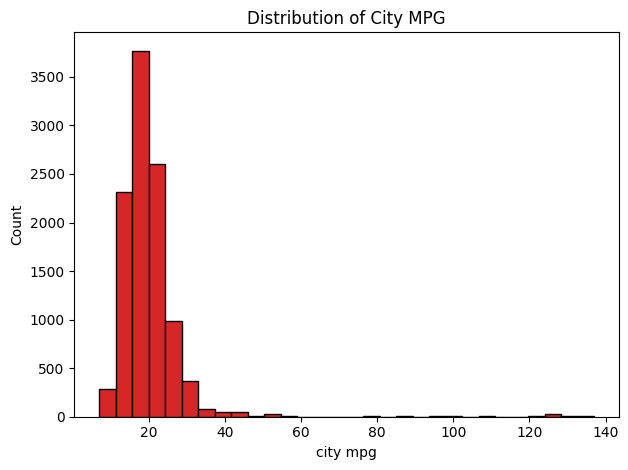

In [87]:
if "city mpg" in df.columns:
    plt.figure()
    plt.hist(df["city mpg"].dropna(), bins=30, color="#d62728", edgecolor="black")
    plt.title("Distribution of City MPG")
    plt.xlabel("city mpg"); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("/content/hist_city_mpg.png", dpi=150)
    plt.show()


###5.2 Bar chart: Avg MSRP by Vehicle Size

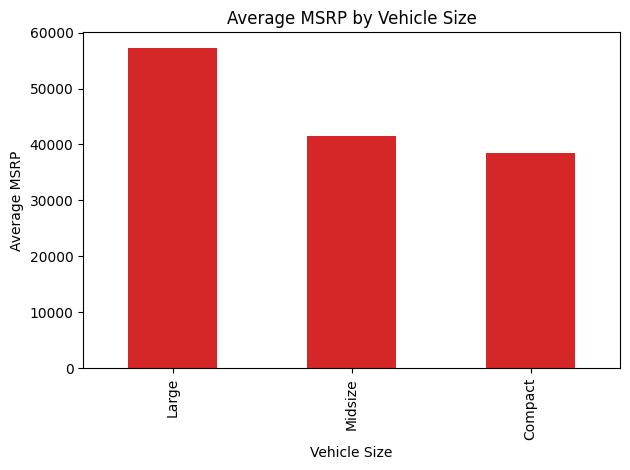

In [68]:
if ("Vehicle Size" in df.columns) and ("MSRP" in df.columns):
    msrp_by_size = df.groupby("Vehicle Size")["MSRP"].mean().sort_values(ascending=False)
    plt.figure()
    msrp_by_size.plot(kind="bar", color="#d62728")
    plt.title("Average MSRP by Vehicle Size")
    plt.xlabel("Vehicle Size"); plt.ylabel("Average MSRP")
    plt.tight_layout()
    plt.savefig("/content/bar_msrp_vehicle_size.png", dpi=150)
    plt.show()


###5.3 Scatter Plot: Engine HP vs MSRP

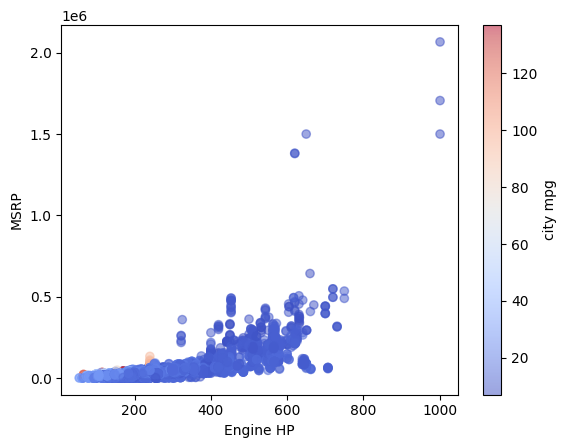

In [74]:
sc = plt.scatter(df["Engine HP"], df["MSRP"],
                 c=df["city mpg"], cmap="coolwarm", alpha=0.5)
plt.xlabel("Engine HP"); plt.ylabel("MSRP")
plt.colorbar(sc, label="city mpg")
plt.show()

###5.4 Boxplot: MSRP by Driven_Wheels

<Figure size 640x480 with 0 Axes>

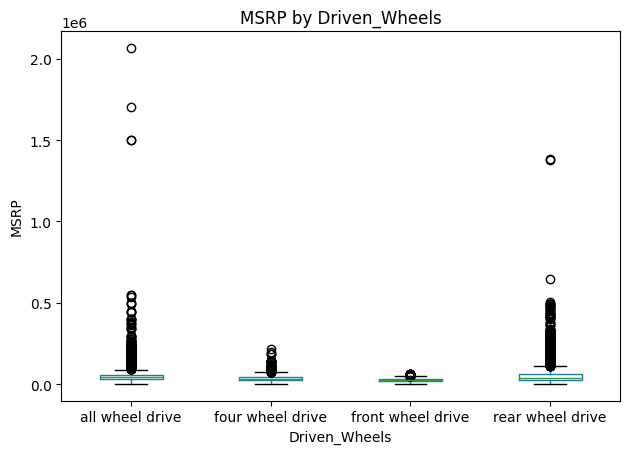

In [47]:
if ("Driven_Wheels" in df.columns) and ("MSRP" in df.columns):
    plt.figure()
    df.boxplot(column="MSRP", by="Driven_Wheels", grid=False)
    plt.title("MSRP by Driven_Wheels"); plt.suptitle("")
    plt.xlabel("Driven_Wheels"); plt.ylabel("MSRP")
    plt.tight_layout()
    plt.savefig("/content/box_msrp_driven_wheels.png", dpi=150)
    plt.show()


###5.5 Line plot: Avg city mpg & highway MPG by Transmission Type

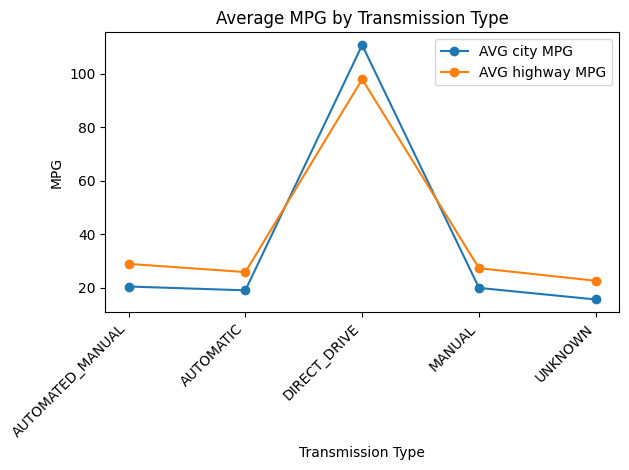

In [65]:
if all(c in df.columns for c in ["Transmission Type","city mpg","highway MPG"]):
    mpg_by_trans = df.groupby("Transmission Type")[["city mpg","highway MPG"]].mean()
    order = list(mpg_by_trans.index)

    plt.figure()
    plt.plot(order, mpg_by_trans["city mpg"].values, marker="o", label="AVG city MPG")
    plt.plot(order, mpg_by_trans["highway MPG"].values, marker="o", label="AVG highway MPG")
    plt.title("Average MPG by Transmission Type")
    plt.xlabel("Transmission Type"); plt.ylabel("MPG")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.savefig("/content/line_mpg_transmission.png", dpi=150)
    plt.show()


#6. Correlation Analysis
####Correlation among: Engine HP, MSRP, Popularity, city mpg, highway MPG.

In [49]:
corr_cols = [c for c in ["Engine HP","MSRP","Popularity","city mpg","highway MPG"] if c in df.columns]
corr_mat = df[corr_cols].corr()
corr_mat

,Engine HP,MSRP,Popularity,city mpg,highway MPG
Engine HP,1.000000,0.653252,0.033523,-0.369470,-0.381799
MSRP,0.653252,1.000000,-0.057551,-0.172427,-0.180456
Popularity,0.033523,-0.057551,1.000000,-0.001823,-0.018806
city mpg,-0.369470,-0.172427,-0.001823,1.000000,0.885889
highway MPG,-0.381799,-0.180456,-0.018806,0.885889,1.000000


###Heatmap (Matplotlib)

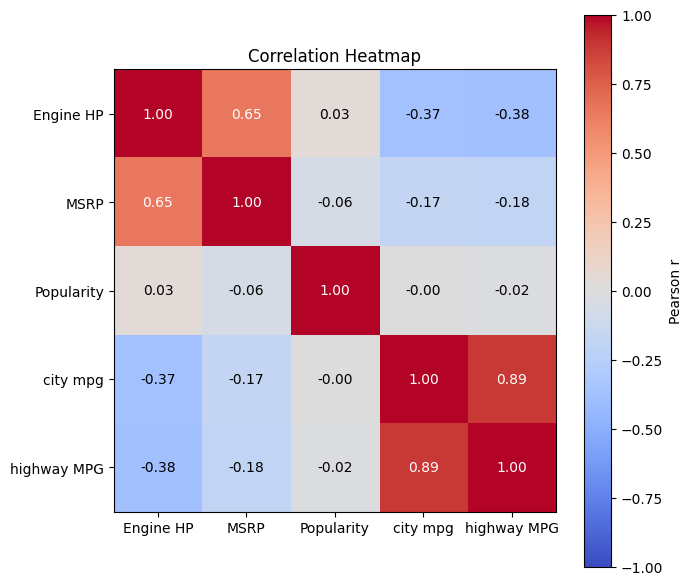

,Engine HP,MSRP,Popularity,city mpg,highway MPG
Engine HP,1.00,0.65,0.03,-0.37,-0.38
MSRP,0.65,1.00,-0.06,-0.17,-0.18
Popularity,0.03,-0.06,1.00,-0.00,-0.02
city mpg,-0.37,-0.17,-0.00,1.00,0.89
highway MPG,-0.38,-0.18,-0.02,0.89,1.00


In [54]:
#  create a heatmap to show correlation between all the numeric variables
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=0, ha="center")
ax.set_yticklabels(cols)

for i in range(len(cols)):
    for j in range(len(cols)):
        val = corr.values[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                color=("white" if abs(val) > 0.5 else "black"))

plt.colorbar(im, ax=ax).set_label("Pearson r")
ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()
corr.round(2)  # show the table


#7. Key Insights and Conclusion

(Fig 1) City MPG distribution (histogram): The distribution is strongly right-skewed (skew ≈ 7.11), meaning most cars get relatively low city MPG while a few have very high mileage (likely EVs/hybrids). Min = 7, Median = 18.0, Mean = 19.73, Max = 137.

(Fig 2) Average MSRP by Vehicle Size (bar chart): Clear upward price trend with size—Large ≈ $53,891 > Midsize ≈ $39,036 > Compact ≈ $34,275. Bigger vehicles generally cost more.

(Fig 3) Engine HP vs MSRP (scatter): Moderate positive correlation (r ≈ 0.66). Cars with more horsepower tend to be priced higher, with a few high-price outliers at the top end.

(Fig 4) MSRP by Driven_Wheels (boxplot): AWD has the highest median MSRP (≈ $41,275), followed by RWD (≈ $35,350), 4WD (≈ $33,060), and FWD (≈ $23,845). Drivetrains associated with performance/traction typically command a premium.

(Fig 5) Correlation heatmap (numeric features): city mpg and highway MPG are strongly positively correlated (r ≈ 0.887). Engine HP correlates positively with MSRP (r ≈ 0.662), supporting the horsepower–price relationship.

(Fig 6) Average MPG by Transmission Type (line plot): DIRECT_DRIVE shows the best efficiency (city ≈ 110.8 / highway ≈ 98.0 MPG, EV-like behavior). Among conventional types, Automated Manual > Manual > Automatic > Unknown on highway MPG, showing clear efficiency gaps by transmission.

Bottom line: Prices scale with vehicle size and horsepower; AWD models are priced higher on median; and transmission type strongly differentiates fuel efficiency, with DIRECT_DRIVE far ahead and a tight city–highway MPG relationship across the board.